# Deformable Style Transfer (ECCV 2020)

In this notebook, we demonstrate deformable style transfer (DST) using STROTSS as the base style transfer method.

Project page: https://sunniesuhyoung.github.io/DST-page/  
Paper: https://arxiv.org/abs/2003.11038  
Code: https://github.com/sunniesuhyoung/DST

In [1]:
!git clone https://github.com/sunniesuhyoung/DST
import os
os.chdir('DST')

fatal: destination path 'DST' already exists and is not an empty directory.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from utils_misc import pil_loader, pil_resize_long_edge_to, pil_to_tensor

In [3]:
# Image will be resized to have a long side of im_side
%env im_size = 256

# If you choose cuda, make sure you select GPU under [Runtime]-[Change runtime type]
%env device = cuda

env: im_size=256
env: device=cuda


## 1. Load content and style images

In [4]:
# Set input image paths
%env content_path = example/content.jpg
%env style_path = example/style.jpg

env: content_path=example/content.jpg
env: style_path=example/style.jpg


In [5]:
# Load and resize input images
content_pil = pil_resize_long_edge_to(pil_loader(os.environ['content_path']), int(os.environ['im_size']))
width, height = content_pil.size
style_pil = pil_resize_long_edge_to(pil_loader(os.environ['style_path']), int(os.environ['im_size']))
content_im_orig = pil_to_tensor(content_pil).to(os.environ['device'])
style_im_orig = pil_to_tensor(style_pil).to(os.environ['device'])

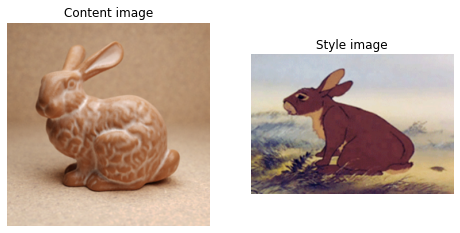

In [6]:
# Plot images
fig = plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(content_pil); plt.axis('off'); plt.title('Content image');
plt.subplot(1, 2, 2)
plt.imshow(style_pil); plt.axis('off'); plt.title('Style image');

## 2. Find matching points with Neural Best-Buddies

Run NBB to find correspondences between images. This will take about a minute or two to run. 

If you have matching points, you can skip this step.

In [7]:
# Set where you want NBB results to be saved
%env pts_path = example/NBBresults

env: pts_path=example/NBBresults


In [8]:
# Run NBB
!python NBB/main.py --results_dir ${pts_path} --imageSize ${im_size} --fast \
  --datarootA ${content_path} --datarootB ${style_path}



---------------------------
Started Neural Best-Buddies
---------------------------

Finding best-buddies for the 5-th level
Scaling and drawing correspondence...

Finding best-buddies for the 4-th level
Scaling and drawing correspondence...

Finding best-buddies for the 3-th level
Scaling and drawing correspondence...

Finding best-buddies for the 2-th level

Finalizing correspondences at level 2

Returning 431 correspondences in total

Saved content points at example/NBBresults/correspondence_A.txt
Saved style points at example/NBBresults/correspondence_B.txt

Finished after 115.439 seconds


## 3. Clean (NBB) points

If you're cleaning NBB points, set **NBB** to 1. This script will filter out points with low activations and select up to **max_num_points** with at least **b** space between them. Then it will remove crossing points.

If you're not cleaning NBB points, set **NBB** to 0, and this script will only remove crossing points. 

This will take a few seconds to run.

In [9]:
# Set paths and other parameters for cleaning points
%env content_pts_path = example/NBBresults/correspondence_A.txt
%env style_pts_path = example/NBBresults/correspondence_B.txt
%env activation_path = example/NBBresults/correspondence_activation.txt
%env output_path = example/CleanedPts
%env NBB = 1
%env max_num_points = 80
%env b = 10

env: content_pts_path=example/NBBresults/correspondence_A.txt
env: style_pts_path=example/NBBresults/correspondence_B.txt
env: activation_path=example/NBBresults/correspondence_activation.txt
env: output_path=example/CleanedPts
env: NBB=1
env: max_num_points=80
env: b=10


In [10]:
!python cleanpoints.py ${content_path} ${style_path} ${content_pts_path} ${style_pts_path} \
  ${activation_path} ${output_path} ${im_size} ${NBB} ${max_num_points} ${b}



--------------------------
Started Cleaning Keypoints
--------------------------

Settings
   content_path: example/content.jpg
   style_path: example/style.jpg
   content_pts_path: example/NBBresults/correspondence_A.txt
   style_pts_path: example/NBBresults/correspondence_B.txt
   activation_path: example/NBBresults/correspondence_activation.txt
   output_path: example/CleanedPts
   NBB: True
   im_size: 256
   max_num_points: 80
   b: 10

Started with 431 points

4 points removed because their activations were less than 1 (NBB-specific processing)

36 points selected in a greedy way (NBB-specific processing)

35 points remaining after removing crossing points

Saved cleaned content points at example/CleanedPts/correspondence_A.txt
Saved cleaned style points at example/CleanedPts/correspondence_B.txt
Saved cleaned activations at example/CleanedPts/correspondence_activation.txt

Finished after 3.425 seconds


In [11]:
%env content_marked = example/CleanedPts/A_selected_final.png
%env style_marked = example/CleanedPts/B_selected_final.png

env: content_marked=example/CleanedPts/A_selected_final.png
env: style_marked=example/CleanedPts/B_selected_final.png


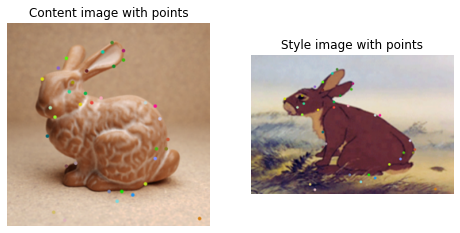

In [12]:
# Load and plot images with points marked
content_marked_pil = pil_resize_long_edge_to(pil_loader(os.environ['content_marked']), int(os.environ['im_size']))
style_marked_pil = pil_resize_long_edge_to(pil_loader(os.environ['style_marked']), int(os.environ['im_size']))

fig = plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(content_marked_pil); plt.axis('off'); plt.title('Content image with points');
plt.subplot(1, 2, 2)
plt.imshow(style_marked_pil); plt.axis('off'); plt.title('Style image with points');

## 4. Run DST

Finally, run deformable style transfer. Stylization will take a few minutes.

By default, DST will stylize the image at three scales (small to big) with **max_iter** iterations at each scale. Change **content_weight** (alpha) and **warp_weight** (beta) to control the relative importance of content preservation and spatial deformation to stylization, and **reg_weight** (gamma) to control the amount of regularization on the deformation.

Set **verbose** to 1 to get the individual loss term values during training.  
Set **save_intermediate** to 1 to get intermediate stylized images every **checkpoint_iter** iterations.  
Set **save_extra** to 1 to get additional plots (e.g. content/stylized images naively warped, content image with DST warp) with points and arrows marked.

In [13]:
%env content_pts_path = example/CleanedPts/correspondence_A.txt
%env style_pts_path = example/CleanedPts/correspondence_B.txt
%env output_dir = example/DSTresults
%env output_prefix = example
%env max_iter = 250
%env checkpoint_iter = 50
%env content_weight = 8
%env warp_weight = 0.5
%env reg_weight = 50
%env optim = sgd
%env lr = 0.2
%env verbose = 0
%env save_intermediate = 0
%env save_extra = 0

env: content_pts_path=example/CleanedPts/correspondence_A.txt
env: style_pts_path=example/CleanedPts/correspondence_B.txt
env: output_dir=example/DSTresults
env: output_prefix=example
env: max_iter=250
env: checkpoint_iter=50
env: content_weight=8
env: warp_weight=0.5
env: reg_weight=50
env: optim=sgd
env: lr=0.2
env: verbose=0
env: save_intermediate=0
env: save_extra=0


In [ ]:
!python -W ignore main.py ${content_path} ${style_path} ${content_pts_path} ${style_pts_path} \
  ${output_dir} ${output_prefix} ${im_size} ${max_iter} \
  ${checkpoint_iter} ${content_weight} ${warp_weight} ${reg_weight} ${optim} \
  ${lr} ${verbose} ${save_intermediate} ${save_extra} ${device}



---------------------------------
Started Deformable Style Transfer
---------------------------------

Settings
   content_path: example/content.jpg
   style_path: example/style.jpg
   content_pts_path: example/CleanedPts/correspondence_A.txt
   style_pts_path: example/CleanedPts/correspondence_B.txt
   output_dir: example/DSTresults
   output_prefix: example
   im_size: 256
   max_iter: 250
   checkpoint_iter: 50
   content_weight: 8.0
   warp_weight: 0.5
   reg_weight: 50.0
   optim: sgd
   lr: 0.2
   verbose: False
   save_intermediate: False
   save_extra: False
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:20<00:00, 26.8MB/s]

Optimizing at scale 1, image size (64, 64)
   STEP 000: Loss 14.386
   STEP 050: Loss 12.708
   STEP 100: Loss 12.071
   STEP 150: Loss 11.635
   STEP 200: Loss 11.227

Optimizing at scale 2, image size (128, 128)
   STEP 000: Loss 12.520
   STEP 050: Loss 9.980

In [ ]:
%env result_path = example/DSTresults/example.png

In [ ]:
# Load the output image
result_pil = pil_resize_long_edge_to(pil_loader(os.environ['result_path']), int(os.environ['im_size']))

In [ ]:
# Plot input and output images
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(content_pil); plt.axis('off'); plt.title('Content image');
plt.subplot(1, 3, 2)
plt.imshow(style_pil); plt.axis('off'); plt.title('Style image');
plt.subplot(1, 3, 3)
plt.imshow(result_pil); plt.axis('off'); plt.title('DST output');